In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from citeline.embedders import Embedder
from citeline.database.milvusdb import MilvusDB
from citeline.query_expander import get_expander

tqdm.pandas()
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)

In [2]:
QUERY_EXPANSION = "add_prev_3"
examples = pd.read_json("data/dataset/nontrivial_checked.jsonl", lines=True)
expander = get_expander(QUERY_EXPANSION, path_to_data="data/preprocessed/reviews.jsonl")
print(f"Using query expansion: {expander}")
examples["sent_no_cit"] = expander(examples)

# Add vector column to examples
examples["vector"] = examples.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)

# Denormalize on citation_dois (targets)
examples = examples.explode("citation_dois", ignore_index=True)
print(f"Number of samples after denormalization: {examples.shape[0]}")
examples.rename(columns={"citation_dois": "target_doi"}, inplace=True)

Using query expansion: QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 14735/14735 [24:57<00:00,  9.84it/s] 

Number of samples after denormalization: 18801


In [8]:
examples.head()

,source_doi,sent_original,sent_no_cit,sent_idx,target_doi,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1016/j.newar.2024.101694,"Subsequently, Andrews et al. (2017) selected a...",1 pc. Similar separation distributions had bee...,58,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],"Subsequently, [REF] selected a wide binary can...","[-0.013162441, -0.09026434, -0.012011871, -0.0..."
1,10.1016/j.newar.2024.101694,Andrews et al. (2017) investigated how the sep...,"Subsequently, Andrews et al. (2017) selected a...",61,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],[REF] investigated how the separation of their...,"[-0.07659448, -0.06426388, -0.007819012, 0.005..."
2,10.1016/j.newar.2024.101694,This led Andrews et al. (2017) to conclude tha...,Andrews et al. (2017) investigated how the sep...,64,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],This led [REF] to conclude that most of the pa...,"[-0.041363277, -0.06723215, -0.009438724, 0.03..."
3,10.1016/j.newar.2024.101694,It may also owe in part to the mass ratio dist...,The sample contains 97 resolved WD+MS binaries...,90,10.1093/mnras/stz2480,20240601,[2019MNRAS.489.5822E],It may also owe in part to the mass ratio dist...,"[-0.044531927, -0.07250536, -0.009316289, 0.05..."
4,10.1016/j.newar.2024.101694,Hwang et al. (2022c) used a related method to ...,This approach forward-models the distribution ...,110,10.3847/2041-8213/ac7c70,20240601,[2022ApJ...933L..32H],[REF] used a related method to study the eccen...,"[-0.04475004, -0.016533192, -0.007177423, 0.05..."


In [9]:
db = MilvusDB()
def most_similar_to_query(example: pd.Series) -> np.ndarray:
    """
    Takes in an example (with 'vector' column already set), and from the candidates
    (returned entities with that doi from the database), returns the vector most similar
    to the example's vector.

    """
    # Converts 'vector' column to rows * dim array, holding the candidate vectors
    candidates = db.select_by_doi(example.target_doi, collection_name="qwen06_chunks")
    candidate_vectors = np.stack(candidates["vector"])
    best_idx = np.argmax(np.dot(candidate_vectors, example["vector"]))
    best_vector = candidate_vectors[best_idx]
    return best_vector

In [52]:
Q = np.array(examples["vector"].tolist())
Q_mean = Q.mean(axis=0, keepdims=True)
print(f"Q mean length: {np.linalg.norm(Q_mean)}")

Q_centered = Q - Q_mean
print(f"Q centered: {Q_centered.shape}")


T = np.array([most_similar_to_query(row) for _, row in tqdm(examples.iterrows(), total=len(examples))])
T_mean = T.mean(axis=0, keepdims=True)
print(f"T mean length: {np.linalg.norm(T_mean)}")
T_centered = T - T_mean
print(f"T centered: {T_centered.shape}")

Q mean length: 0.5456443428993225
Q centered: (18801, 1024)


100%|██████████| 18801/18801 [02:26<00:00, 128.59it/s]


T mean length: 0.575112388274719
T centered: (18801, 1024)


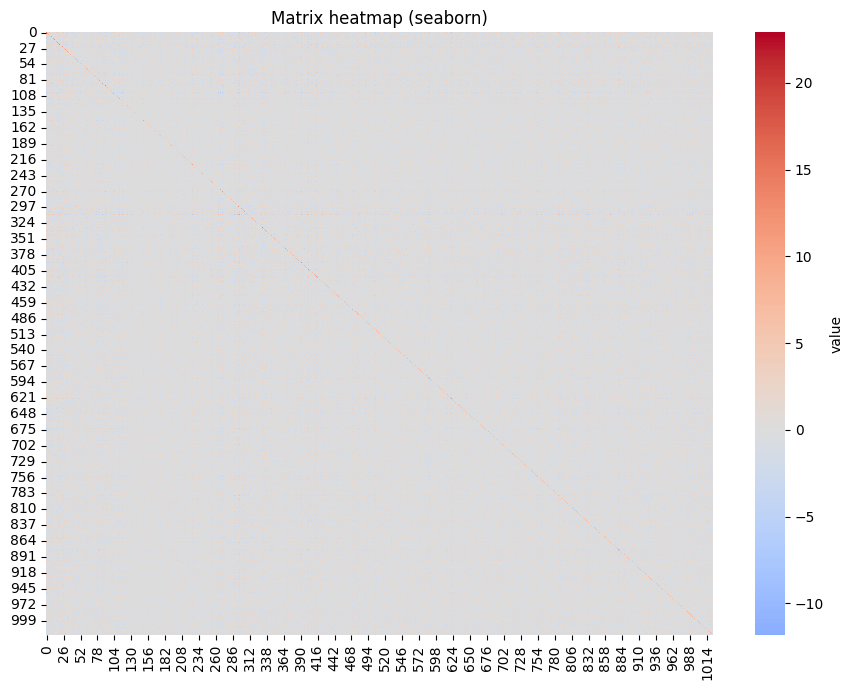

In [ ]:


M = T_centered.T @ Q_centered

In [54]:

U, S, Vt = np.linalg.svd(M)
R = U @ Vt

print("det R:", np.linalg.det(R))
# Only allow rotation, not reflection
if np.linalg.det(R) < 0:
    D = np.eye(R.shape[0])
    D[-1, -1] = -1
    R = U @ D @ Vt
    print("corrected det R:", np.linalg.det(R))
print("R shape:", R.shape)

det R: 1.0000000000001597
R shape: (1024, 1024)


In [55]:
print("rank approx:", np.sum(S > 1e-8))
print("singular values (top/last):", S[:30], S[-5:])
# Compute the cumulative explained variance
s_total = np.sum(S**2)
print("Total variance (sum of squares of singular values):", s_total)


rank approx: 1024
singular values (top/last): [459.90096525 352.11326513 297.072677   265.60328093 262.90864138
 194.52710368 176.55487606 144.85257588 119.62873987 111.03499443
 110.28304813 102.46767265  89.63731623  82.602582    79.96607939
  74.05067534  72.34389278  69.86491292  68.92159698  64.91036481
  63.21139164  59.96023631  57.49930309  56.29647047  54.96003493
  51.5469686   49.15000086  47.85260482  47.25176794  45.79104441] [0.0010112  0.0005362  0.0003763  0.00025713 0.00013321]
Total variance (sum of squares of singular values): 827769.1201326539


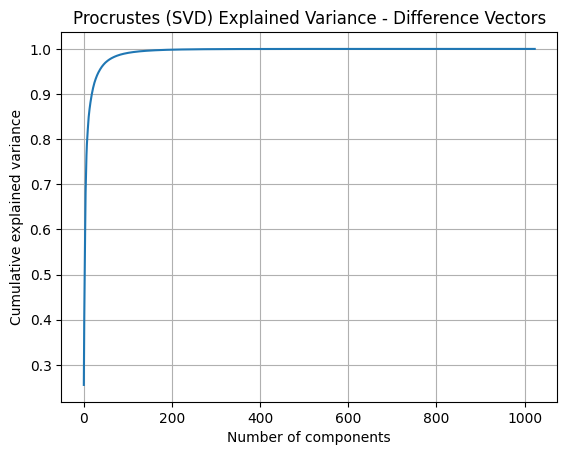

In [56]:
# Proportion of variance explained by each component
plt.plot(np.cumsum(S**2) / s_total)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Procrustes (SVD) Explained Variance - Difference Vectors")
plt.grid()
plt.savefig("plots/procrustes_explained_variance.png", dpi=300)
plt.show()

In [ ]:
import random

research_dois = set(examples.target_doi)
print(research_dois)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def negative_vectors(example: pd.Series, n=5):
    # Get all target DOIs for this example, sample from those not cited
    rows = examples[(examples.source_doi == example.source_doi) & (examples.sent_idx == example.sent_idx)]
    citation_dois = set(rows.target_doi)
    neg_dois = list(research_dois - citation_dois)
    neg_samples = random.sample(neg_dois, n)
    
    # Get vectors for negative samples
    neg_vectors = np.zeros((n, embedder.dim))
    for i, doi in enumerate(neg_samples):
        records = db.select_by_doi(doi, collection_name="qwen06_chunks")
        sample_record = records.sample(n=1).iloc[0]
        neg_vectors[i] = np.array(sample_record['vector'])
    return neg_vectors

[[-0.01727995  0.03148478 -0.00867676 ... -0.06443612 -0.0113189
   0.02318208]
 [-0.01736962  0.00247364 -0.01040095 ... -0.01726148 -0.01112188
  -0.02279182]
 [-0.07963782 -0.0584705  -0.00978606 ... -0.00529673  0.01754657
  -0.00829163]
 [ 0.00395723  0.03307319 -0.0059254  ... -0.00987     0.0139679
   0.00215534]
 [-0.01600535  0.03150532 -0.00970247 ...  0.03275198  0.08765952
  -0.01036322]]


Citation DOIs: {'10.1046/j.1365-8711.2000.03810.x', '10.1086/316394', '10.1086/186883'}

In [63]:
print(np.linalg.norm(R.T @ R - np.eye(R.shape[0])))  # should be ≈ 0

1.7320759197828664e-13


In [78]:
differences_to_target = []
differences_to_negative = []
for _, row in examples.iterrows():
    if _ == 200:
        break
    query_vector = row['vector']
    target_vector = most_similar_to_query(row)
    aligned_query_vector = query_vector @ R
    before = cosine_similarity(query_vector, target_vector)
    after = cosine_similarity(aligned_query_vector, target_vector)

    differences_to_target.append(after - before)
    neg_vectors = negative_vectors(row, n=5)
    batch_distance_to_negative = []
    for neg_vector in neg_vectors:
        before_neg = cosine_similarity(query_vector, neg_vector)
        after_neg = cosine_similarity(aligned_query_vector, neg_vector)
        batch_distance_to_negative.append(after_neg - before_neg)
        differences_to_negative.append(after_neg - before_neg)
    print(_)
    print(f"Improvement to target: {after - before:.4f}")
    print(f"Distance to negatives: {np.mean(batch_distance_to_negative):.4f} ± {np.std(batch_distance_to_negative):.4f}")
    print("---")
print(f"Average improvement (target): {np.mean(differences_to_target):.6f} ± {np.std(differences_to_target):.6f}")
print(f"Average improvement (negative): {np.mean(differences_to_negative):.6f} ± {np.std(differences_to_negative):.6f}")

0
Improvement to target: -0.0923
Distance to negatives: -0.0504 ± 0.0104
---
1
Improvement to target: -0.0790
Distance to negatives: -0.0438 ± 0.0082
---
2
Improvement to target: -0.0804
Distance to negatives: -0.0321 ± 0.0135
---
3
Improvement to target: -0.0559
Distance to negatives: -0.0373 ± 0.0132
---
4
Improvement to target: -0.0864
Distance to negatives: -0.0608 ± 0.0106
---
5
Improvement to target: -0.0854
Distance to negatives: -0.0595 ± 0.0079
---
6
Improvement to target: -0.0896
Distance to negatives: -0.0522 ± 0.0079
---
7
Improvement to target: -0.0933
Distance to negatives: -0.0533 ± 0.0087
---
8
Improvement to target: -0.0840
Distance to negatives: -0.0556 ± 0.0108
---
9
Improvement to target: -0.0909
Distance to negatives: -0.0497 ± 0.0089
---
10
Improvement to target: -0.0800
Distance to negatives: -0.0573 ± 0.0121
---
11
Improvement to target: -0.0770
Distance to negatives: -0.0528 ± 0.0106
---
12
Improvement to target: -0.0778
Distance to negatives: -0.0481 ± 0.0050


In [ ]:
# Convert difference vectors to spherical coordinates
difference_vectors = T - Q


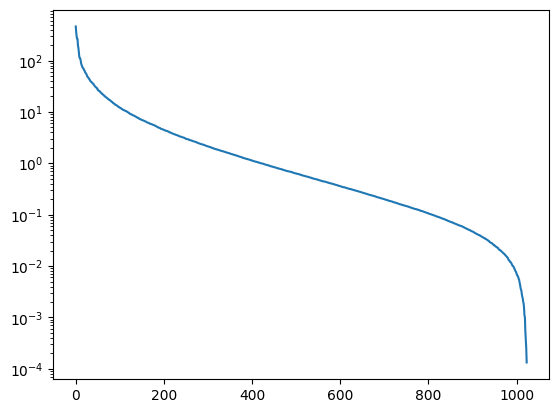

In [ ]:
# U, S, Vt = np.linalg.svd(M)
# print("U shape:", U.shape)
# print("S shape:", S.shape)
# print("Vt shape:", Vt.shape)
# print("Vt_trunc shape:", Vt[:1, :].shape)
# print("S_trunc shape:", S[:1].shape)
# print("U_trunc shape:", U[:, 0:1].shape)
# trunc = U[:, 0:1] @ (S[:1] * Vt[0:1, :])
# print("trunc shape:", trunc.shape)
# print("trunc rank:", np.linalg.matrix_rank(trunc))
# print(trunc)


plt.semilogy(S)  # plot singular values

In [ ]:
np.save('qwen06_chunks_rotation_n2000.npy', R)

In [ ]:
sigma1 = S[0]
eps = 1e-6  # try 1e-6 .. 1e-8 as needed
r = 50
# r = np.searchsorted(S / sigma1 < eps, True)  # first index where ratio < eps
print(f"Chosen rank r: {r}")
if r == 0:
    r = len(S)  # fallback if no small ones found
# alternative: r = np.searchsorted(np.cumsum(S**2) / np.sum(S**2), 0.99) + 1

# build small rotation in top-r
Ur = U[:, :r]  # n x r
Vr = Vt[:r, :].T  # n x r  (since Vt[:r,:] is r x n)
Msmall = Ur.T @ M @ Vr  # should be r x r but simpler compute: Tproj.T @ Qproj if you had them
# simpler: compute r x r cross-covariance directly via projections:
# Qproj = Q_all @ Ur  # expensive if many, but doable; here we reuse M decomposition
# but we can use SVD of the small Mslice: compute Us, Ss, Vts = svd(Ur.T @ M @ Vr)

# directly SVD the r x r matrix (numerically stable):
Us, Ss, Vts = np.linalg.svd(Ur.T @ M @ Vr, full_matrices=False)
Rsmall = Us @ Vts
# ensure proper rotation (det +1)
if np.linalg.det(Rsmall) < 0:
    D = np.eye(r)
    D[-1, -1] = -1
    Rsmall = Us @ D @ Vts

# map basis Ur to rotated basis Ur @ Rsmall @ Ur.T, then add identity on complement
R_full = Ur @ Rsmall @ Ur.T + (np.eye(1024) - Ur @ Ur.T)
print("det R_full:", np.linalg.det(R_full))
print(R_full.shape)
print(R_full)

In [ ]:
np.save('qwen06_chunks_fullR.npy', R)

In [ ]:
v1 = Vt[0, :]
u1 = U[:, 0]
print("v1 shape:", v1.shape)
print("u1 shape:", u1.shape)

In [ ]:
query_vectors = np.stack(examples['vector'].to_numpy())
print("query_vectors shape:", query_vectors.shape)
X = np.dot(v1, query_vectors.T)
print(X.shape)

In [ ]:
target_vectors = np.stack([most_similar_to_query(row) for _, row in tqdm(examples.iterrows(), total=len(examples))])
Y = np.dot(u1, target_vectors.T)
print(Y.shape)
plt.scatter(X, Y)

In [ ]:
np.corrcoef(X, Y)

In [79]:
from sklearn.decomposition import PCA
difference_vectors = T - Q


pca = PCA(n_components=3)
diffs_reduced = pca.fit_transform(difference_vectors)

Explained variance ratios (first 10): [0.01240934 0.01170661 0.01086627 0.01000957 0.00960797 0.00932786
 0.00902922 0.0088636  0.00853971 0.00806176]
Cumulative explained variance (first 10): [0.01240934 0.02411595 0.03498223 0.04499179 0.05459976 0.06392762
 0.07295683 0.08182044 0.09036015 0.09842191]


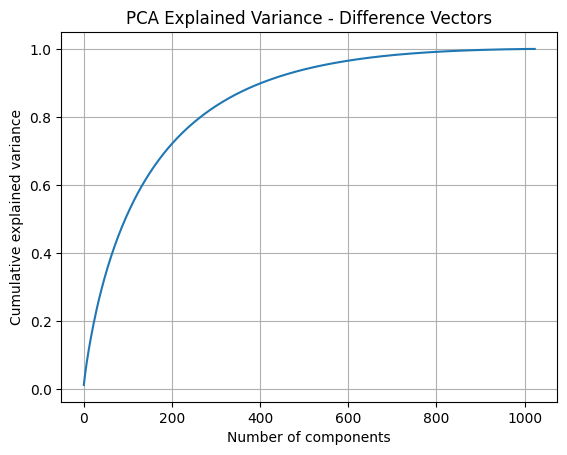

In [80]:
# Plot variance explained
pca_full = PCA()
pca_full.fit(difference_vectors)
print("Explained variance ratios (first 10):", pca_full.explained_variance_ratio_[:10])
print("Cumulative explained variance (first 10):", np.cumsum(pca_full.explained_variance_ratio_)[:10])
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance - Difference Vectors")
plt.grid()
# plt.savefig("plots/pca_explained_variance.png", dpi=300)
plt.show()

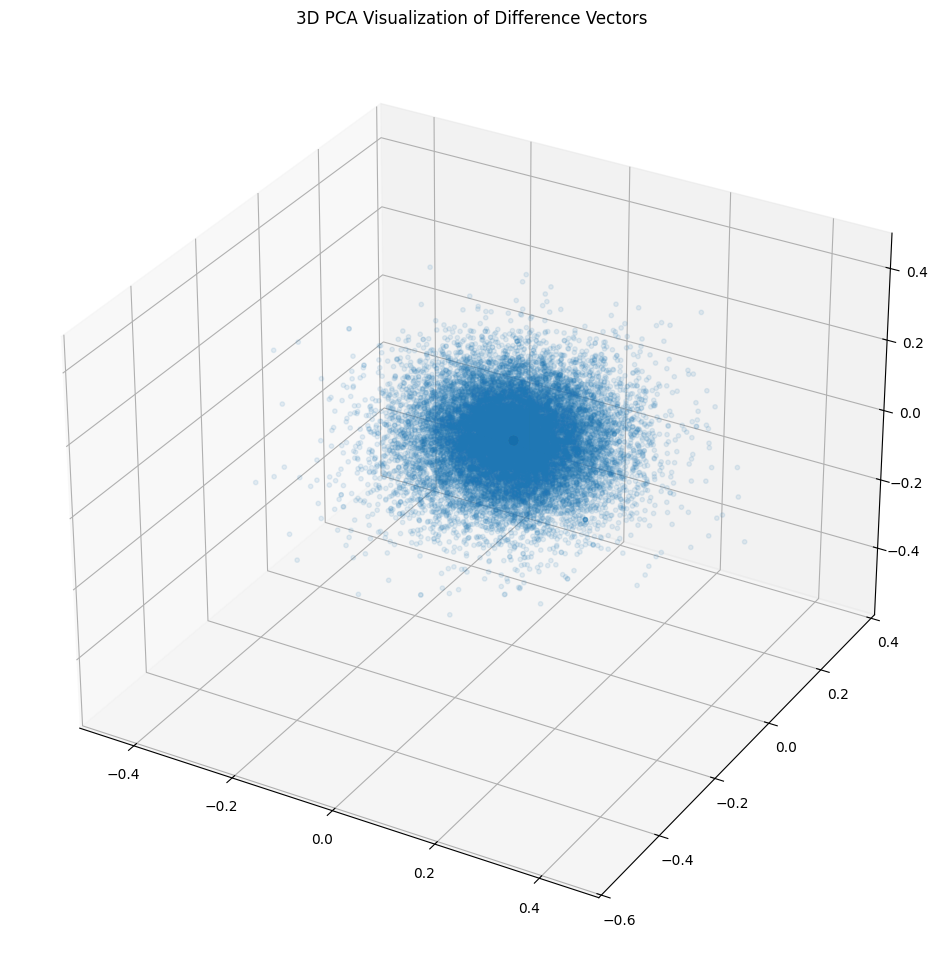

In [82]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(diffs_reduced[:, 0], diffs_reduced[:, 1], diffs_reduced[:, 2], s=10, alpha=0.1)
ax.scatter(0, 0, 0, color='black', s=40, label='Origin', alpha=1)
ax.set_title("3D PCA Visualization of Difference Vectors")
plt.show()

In [84]:
# Convert Q and T rows to spherical coordinates

from citeline.helpers.coordinate_converters import euclidean_to_spherical, spherical_to_euclidean
Q_spherical = np.array([euclidean_to_spherical(vec) for vec in Q])
T_spherical = np.array([euclidean_to_spherical(vec) for vec in T])
spherical_diffs = T_spherical - Q_spherical
spherical_diffs

array([[ 8.39925354e-08, -1.46773324e-02, -8.63644681e-03, ...,
        -2.93715836e-01, -2.12908172e+00, -5.05698932e+00],
       [ 6.57897656e-08, -4.66357163e-02, -2.06957506e-02, ...,
        -2.67057332e-01, -8.62015770e-01,  4.64241925e-01],
       [-2.99650061e-08, -4.25588761e-02,  1.83138898e-03, ...,
        -4.35812790e-01, -1.79255372e-01, -3.27910837e+00],
       ...,
       [ 1.44872425e-08,  8.96670099e-02,  2.99828715e-02, ...,
         4.91401594e-01, -1.13905179e-01,  2.56498809e-01],
       [ 7.19640014e-09,  5.18945950e-02,  2.18301104e-02, ...,
         4.93306387e-01, -5.94818821e-01, -5.52212805e-01],
       [ 1.14627130e-08,  1.17096397e-03, -2.24091865e-02, ...,
        -6.64745407e-01,  1.05697684e+00,  1.95114228e-01]],
      shape=(18801, 1024))